In [3]:
# Import all necessary libraries.
import numpy as np
from scipy.special import erfc
from sklearn.cluster import KMeans
import matplotlib.pyplot as plt

In [4]:
# Number of QPSK symbols to be transmitted.

N = 100000

In [5]:
#Instanciando um objeto da classe KMeans

km_re = KMeans(n_clusters=4)
km_im = KMeans(n_clusters=4)

In [6]:
#Funções para encontrar a qual símbolo pertence uma amostra

def mod(V):
    ip = np.zeros((len(V),1),dtype=complex)
    inc = 0
    for v in V:
        if(v==0):
            ip[inc] = -1.0 - 1j*1.0
        elif(v==1):
            ip[inc] = -1.0 + 1j*1.0
        elif(v==2):
            ip[inc] = 1.0 - 1j*1.0
        else:
            ip[inc] = 1.0 + 1j*1.0
        inc += 1
    # Normalization of energy to 1.
    s = (1/np.sqrt(2))*ip;
    return s

def demod(c):
    c_seq = mod(np.array([0,1,2,3]))
    c_seq = c_seq[:,0]
    e = []
    for i in range(0,len(c_seq)):
        e.append(np.abs(c_seq[i] - c)**2)
    return e.index(np.min(e))

In [7]:
# Create Es/N0 vector.

EsN0dB = np.arange(-2,22,2)
ser_simu = np.zeros(len(EsN0dB))
ser_theo = np.zeros(len(EsN0dB))

for idx in range(0,len(EsN0dB)):
    print('Es/N0 dB:', EsN0dB[idx])
    EsN0Lin = 10.0**(-(EsN0dB[idx]/10.0))

    # Generate N QPSK symbols.
    ip =(2.0 * (np.random.rand(N, 1) >= 0.5) - 1.0) + 1j*(2.0 * (np.random.rand(N, 1) >= 0.5) - 1.0)

    # Normalization of energy to 1.
    s = (1/np.sqrt(2))*ip;
    
    # Generate noise vector with unitary variance.
    noise = np.sqrt(1.0/2.0)*(np.random.randn(N, 1) + 1j*np.random.randn(N, 1))

    # Pass symbols through AWGN channel.
    y = s + np.sqrt(EsN0Lin)*noise

    # Fit model for real part.
    km_re.fit(y.real)

    # Fit model for imaginary parts.
    km_im.fit(y.imag)

    # Prediction for real part.
    detected_ip_re = km_re.predict(y.real).reshape(N, 1)

    # Prediction for imaginary part.
    detected_ip_im = km_im.predict(y.imag).reshape(N, 1)
    
    for i in range (0,N):
        detected_ip_re[i] = demod(km_re.cluster_centers_[detected_ip_re[i]])
        detected_ip_im[i] = demod(km_im.cluster_centers_[detected_ip_im[i]])
        ip.real[i] = demod(ip.real[i])
        ip.imag[i] = demod(ip.imag[i])
    
    # Simulated QPSK BER.
    error_re = (ip.real != detected_ip_re)
    error_im = (ip.imag != detected_ip_im)
    error = 0;
    for i in range(0, N):
        if(error_re[i]==True or error_im[i]==True):
            error = error + 1
            
    ser_simu[idx] = 1.0 * error / N
    
    # Theoretical BPSK BER.
    ser_theo[idx] = erfc( np.sqrt( 0.5*(10.0**(EsN0dB[idx]/10.0)) ) ) - (1/4)*(erfc(np.sqrt(0.5*(10.0**(EsN0dB[idx]/10.0)))))**2.0

Es/N0 dB: -2
Es/N0 dB: 0
Es/N0 dB: 2
Es/N0 dB: 4
Es/N0 dB: 6
Es/N0 dB: 8
Es/N0 dB: 10
Es/N0 dB: 12
Es/N0 dB: 14
Es/N0 dB: 16
Es/N0 dB: 18
Es/N0 dB: 20


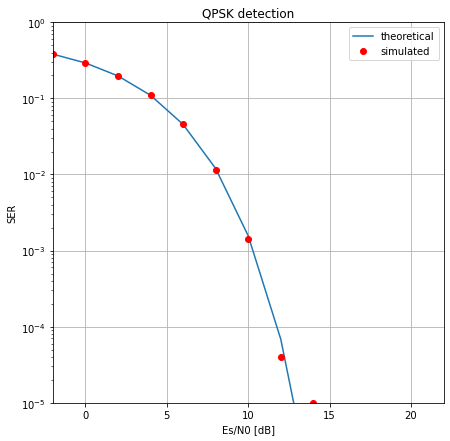

In [9]:
# Plot Es/N0 versus BER values.
fig = plt.figure(figsize=(7,7))
plt.plot(EsN0dB, ser_theo, label='theoretical')
plt.plot(EsN0dB, ser_simu, 'ro', label='simulated')
plt.xscale('linear')
plt.yscale('log')
plt.xlabel('Es/N0 [dB]')
plt.ylabel('SER')
plt.grid(True)
plt.title('QPSK detection')
plt.legend()
plt.xlim([-2, 22])
plt.ylim([1e-5, 1])
plt.show()